In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteQXYJZ6/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteQXYJZ6/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteQXYJZ6/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [4]:
encoder = info.features['text'].encoder

In [5]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [6]:
sample_string = 'Hi TensorFlow.'
encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))
original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [1052, 7961, 6307, 2327, 4043, 2120, 7975]
The original string: "Hi TensorFlow."


In [7]:
assert original_string == sample_string

In [8]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

1052 ----> Hi
7961 ---->  
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


### **Prepare the data for training**

In [9]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [10]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)
test_dataset = test_dataset.padded_batch(BATCH_SIZE)

### **Create the model**

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [12]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### **Train the model**


In [13]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 45s 114ms/step - loss: 0.6160 - accuracy: 0.5984 - val_loss: 0.4237 - val_accuracy: 0.7995
Epoch 2/10
391/391 [==============================] - 44s 113ms/step - loss: 0.3235 - accuracy: 0.8662 - val_loss: 0.3406 - val_accuracy: 0.8370
Epoch 3/10
391/391 [==============================] - 45s 114ms/step - loss: 0.2432 - accuracy: 0.9064 - val_loss: 0.3318 - val_accuracy: 0.8438
Epoch 4/10
391/391 [==============================] - 45s 115ms/step - loss: 0.2063 - accuracy: 0.9237 - val_loss: 0.3304 - val_accuracy: 0.8672
Epoch 5/10
391/391 [==============================] - 44s 113ms/step - loss: 0.1796 - accuracy: 0.9357 - val_loss: 0.3387 - val_accuracy: 0.8609
Epoch 6/10
391/391 [==============================] - 44s 113ms/step - loss: 0.1563 - accuracy: 0.9465 - val_loss: 0.4069 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 44s 112ms/step - loss: 0.1393 - accuracy: 0.9531 - val_loss: 0.4080 - val_ac

In [14]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 19s 49ms/step - loss: 0.4735 - accuracy: 0.8453
Test Loss: 0.47349920868873596
Test Accuracy: 0.8452799916267395


In [15]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [16]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)
  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
  return (predictions)

In [17]:
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.44330397]]


In [18]:
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.63352984]]


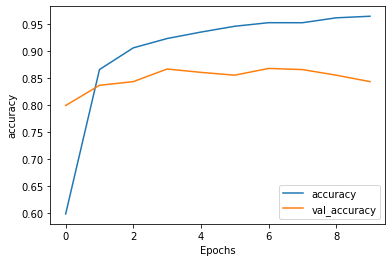

In [19]:
plot_graphs(history, 'accuracy')

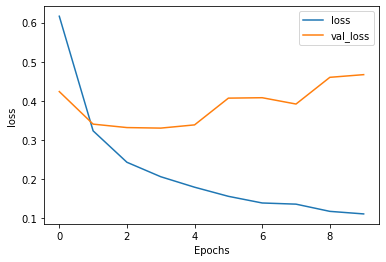

In [20]:
plot_graphs(history, 'loss')

### Stack two or more LSTM layers

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 76s 194ms/step - loss: 0.6455 - accuracy: 0.5650 - val_loss: 0.4623 - val_accuracy: 0.7979
Epoch 2/10
391/391 [==============================] - 74s 190ms/step - loss: 0.3625 - accuracy: 0.8541 - val_loss: 0.3521 - val_accuracy: 0.8479
Epoch 3/10
391/391 [==============================] - 75s 192ms/step - loss: 0.2633 - accuracy: 0.9026 - val_loss: 0.3941 - val_accuracy: 0.8641
Epoch 4/10
391/391 [==============================] - 75s 192ms/step - loss: 0.2153 - accuracy: 0.9247 - val_loss: 0.3565 - val_accuracy: 0.8615
Epoch 5/10
391/391 [==============================] - 75s 193ms/step - loss: 0.1869 - accuracy: 0.9390 - val_loss: 0.3673 - val_accuracy: 0.8568
Epoch 6/10
391/391 [==============================] - 74s 189ms/step - loss: 0.1619 - accuracy: 0.9496 - val_loss: 0.3957 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 74s 189ms/step - loss: 0.1508 - accuracy: 0.9538 - val_loss: 0.4190 - val_ac

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 35s 89ms/step - loss: 0.5181 - accuracy: 0.8469
Test Loss: 0.5180532336235046
Test Accuracy: 0.8469200134277344


In [25]:
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-2.586943]]


In [26]:
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-3.759956]]


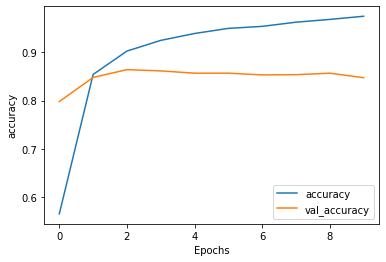

In [27]:
plot_graphs(history, 'accuracy')

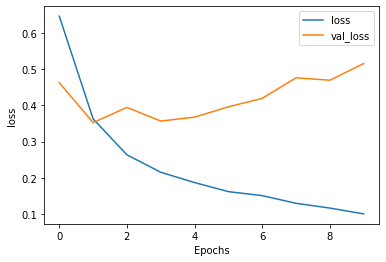

In [28]:
plot_graphs(history, 'loss')